In [2]:
# Install required dependencies for LunarLander
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399056 sha256=428489bfb9b52e93f4931993d7aa4f430cb377f77dc96f67f252f1025852b54f
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


# **Simple DQN**

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt


# ----- Neural Network -----
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


# ----- Epsilon-Greedy Policy -----
def select_action(model, state, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            q_values = model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()


/tmp/ipython-input-889342964.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(q_value, torch.tensor(target))


Episode 100/500, Avg Reward (last 100): -149.84, Epsilon: 0.606
Episode 200/500, Avg Reward (last 100): -91.99, Epsilon: 0.367
Episode 300/500, Avg Reward (last 100): -30.48, Epsilon: 0.222
Episode 400/500, Avg Reward (last 100): 64.01, Epsilon: 0.135
Episode 500/500, Avg Reward (last 100): 149.99, Epsilon: 0.082


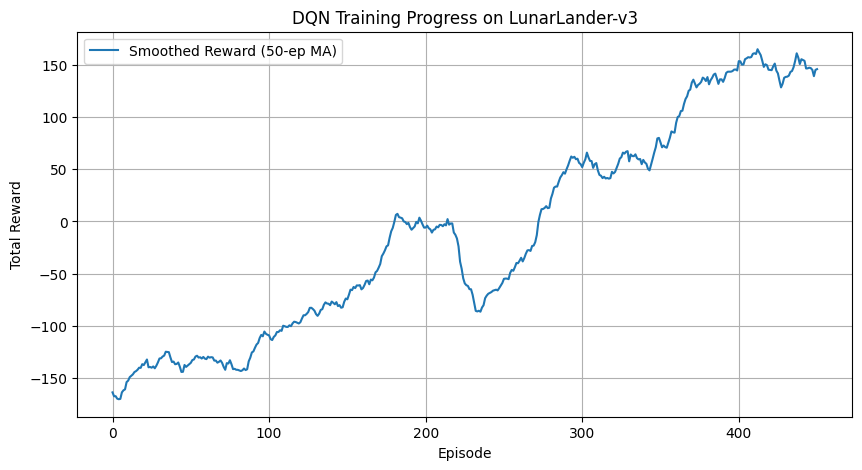

In [4]:
# ----- Main Training Loop -----
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = QNetwork(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 500

rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(model, state, epsilon, action_dim)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Compute TD target
        with torch.no_grad():
            next_q = model(torch.tensor(next_state, dtype=torch.float32))
            max_next_q = torch.max(next_q)
            target = reward + gamma * max_next_q * (1 - done)

        # Compute current Q estimate
        q_values = model(torch.tensor(state, dtype=torch.float32))
        q_value = q_values[action]

        # Compute loss
        loss = loss_fn(q_value, torch.tensor(target))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)

    # Epsilon decay
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Print every 100 episodes
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode+1}/{num_episodes}, Avg Reward (last 100): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

env.close()

# ----- Plotting Reward Curve -----
plt.figure(figsize=(10,5))
plt.plot(np.convolve(rewards_per_episode, np.ones(50)/50, mode='valid'), label='Smoothed Reward (50-ep MA)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress on LunarLander-v3')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'DQN Training Progress per episode')

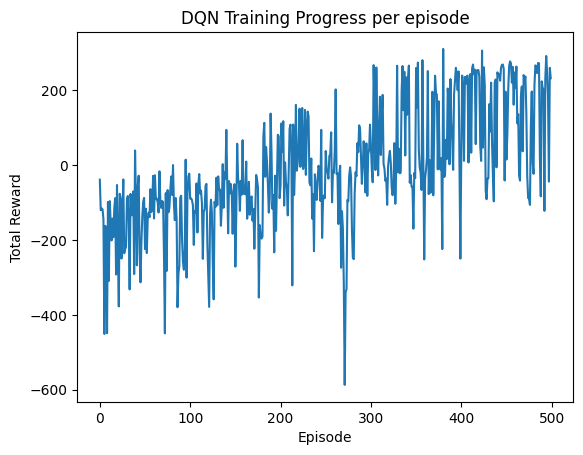

In [5]:
plt.plot(rewards_per_episode, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress per episode')

# **Double DQN**

In [6]:
# ----- Q-Network -----
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, x):
        return self.net(x)


# ----- Replay Buffer -----
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


# ----- Epsilon-Greedy Policy -----
def select_action(model, state, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            q_values = model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()


Episode 100/500, Avg Reward (100 ep): -136.3, Epsilon: 0.740
Episode 200/500, Avg Reward (100 ep): -62.8, Epsilon: 0.548
Episode 300/500, Avg Reward (100 ep): -42.9, Epsilon: 0.406
Episode 400/500, Avg Reward (100 ep): 47.8, Epsilon: 0.301
Episode 500/500, Avg Reward (100 ep): 58.0, Epsilon: 0.223


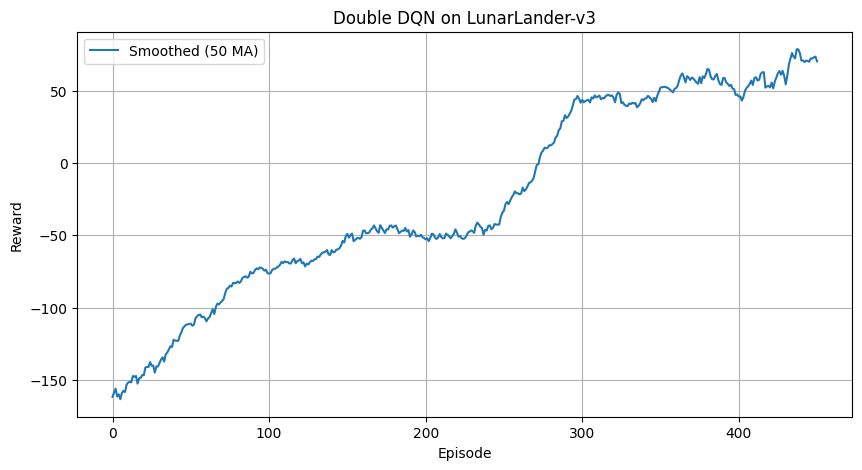

In [8]:
# ----- Training Setup -----
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

main_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(main_net.state_dict())

optimizer = optim.Adam(main_net.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss()   # Huber loss = better stability
buffer = ReplayBuffer(100000)

gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.997          # slower decay for difficult environments
batch_size = 128               # bigger batch helps stability
target_update_interval = 1500  # slightly slower updates
num_episodes = 500

rewards_per_episode = []
steps_done = 0


# ----- Main Loop -----
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        steps_done += 1
        action = select_action(main_net, state, epsilon, action_dim)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # optional: reward clipping helps LunarLander a lot
        clipped_reward = np.clip(reward, -1, 1)

        buffer.push(state, action, clipped_reward, next_state, done)
        state = next_state
        total_reward += reward     # Keep real reward for logging

        # Train
        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            # Current Q estimates
            q_values = main_net(states).gather(1, actions.unsqueeze(1)).squeeze()

            # ----- Double DQN target -----
            with torch.no_grad():
                # online net chooses action
                next_actions = main_net(next_states).argmax(dim=1)

                # target net evaluates action
                next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()

                targets = rewards + gamma * next_q_values * (1 - dones)

            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()

            # gradient clipping prevents divergence
            nn.utils.clip_grad_norm_(main_net.parameters(), max_norm=10)

            optimizer.step()

        # Update target network
        if steps_done % target_update_interval == 0:
            target_net.load_state_dict(main_net.state_dict())

    rewards_per_episode.append(total_reward)

    # Epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Logging
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode+1}/{num_episodes}, "
              f"Avg Reward (100 ep): {avg_reward:.1f}, Epsilon: {epsilon:.3f}")

env.close()


# ----- Plot -----
plt.figure(figsize=(10,5))
plt.plot(np.convolve(rewards_per_episode, np.ones(50)/50, mode='valid'), label='Smoothed (50 MA)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Double DQN on LunarLander-v3')
plt.legend()
plt.grid(True)
plt.show()


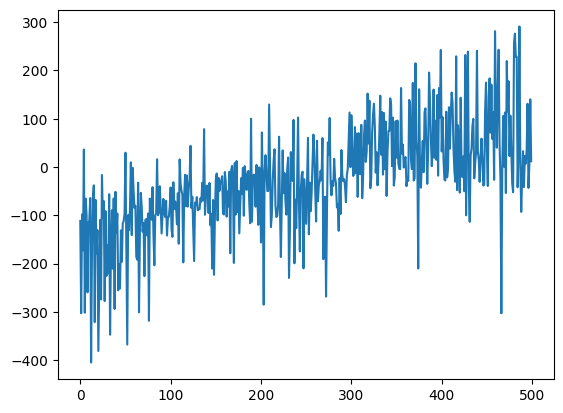

In [9]:
plt.plot(rewards_per_episode, label='Per Episode')

# **Dueling double DQN**

In [14]:
# ----- Dueling Q-Network -----
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingQNetwork, self).__init__()

        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)  # ensure batch dimension for single state

        features = self.feature(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)

        adv_mean = advantage.mean(dim=1, keepdim=True)
        q_values = value + advantage - adv_mean
        return q_values


# ----- Replay Buffer -----
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


# ----- Epsilon-Greedy Policy -----
def select_action(model, state, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)

    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        q_values = model(state)
    return torch.argmax(q_values).item()

Ep 100/500, Avg Reward (100): -142.3, Eps: 0.740
Ep 200/500, Avg Reward (100): -56.8, Eps: 0.548
Ep 300/500, Avg Reward (100): -26.1, Eps: 0.406
Ep 400/500, Avg Reward (100): 33.6, Eps: 0.301
Ep 500/500, Avg Reward (100): 45.9, Eps: 0.223


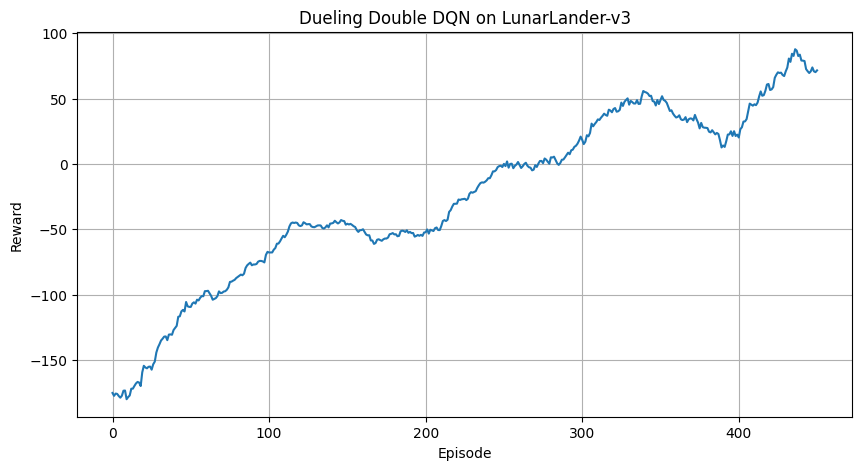

In [16]:
# ----- Training Setup -----
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

main_net = DuelingQNetwork(state_dim, action_dim)
target_net = DuelingQNetwork(state_dim, action_dim)
target_net.load_state_dict(main_net.state_dict())

optimizer = optim.Adam(main_net.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss()
buffer = ReplayBuffer(100000)

gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.997
batch_size = 128
target_update_interval = 1500
num_episodes = 500

rewards_per_episode = []
steps_done = 0

# ----- Main Loop -----
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        steps_done += 1
        action = select_action(main_net, state, epsilon, action_dim)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        clipped_reward = np.clip(reward, -1, 1)   # optional but improves stability
        buffer.push(state, action, clipped_reward, next_state, done)

        state = next_state
        total_reward += reward

        # Train
        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            q_values = main_net(states).gather(1, actions.unsqueeze(1)).squeeze()

            # ------ Double DQN Target ------
            with torch.no_grad():
                next_actions = main_net(next_states).argmax(dim=1)
                next_q = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
                targets = rewards + gamma * next_q * (1 - dones)

            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(main_net.parameters(), 10)
            optimizer.step()

        # Update target weights
        if steps_done % target_update_interval == 0:
            target_net.load_state_dict(main_net.state_dict())

    rewards_per_episode.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"Ep {episode+1}/{num_episodes}, Avg Reward (100): {avg_reward:.1f}, Eps: {epsilon:.3f}")

env.close()

# ----- Plot -----
plt.figure(figsize=(10,5))
plt.plot(np.convolve(rewards_per_episode, np.ones(50)/50, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling Double DQN on LunarLander-v3')
plt.grid(True)
plt.show()


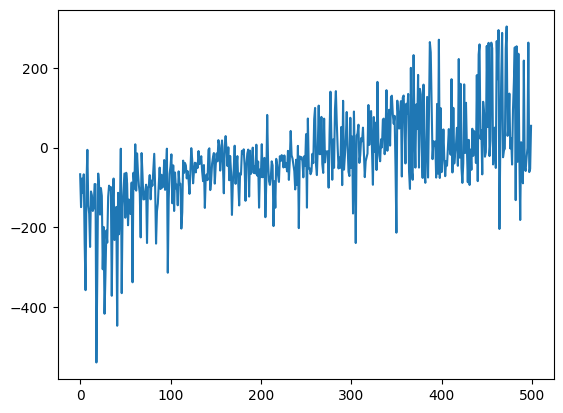

In [17]:
plt.plot(rewards_per_episode, label='Per Episode')